In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "TAC-1" => ["TAC-2", "IRS"],
    "TAC-2" => ["Hair Shaft-cuticle.cortex", "Medulla"]
)

Dict{String, Vector{String}} with 2 entries:
  "TAC-2" => ["Hair Shaft-cuticle.cortex", "Medulla"]
  "TAC-1" => ["TAC-2", "IRS"]

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 6436 ✕ 962

In [8]:
intrinsic_labels = sort(unique(julovelo_adata.obs.celltype))

5-element Vector{String}:
 "Hair Shaft-cuticle.cortex"
 "IRS"
 "Medulla"
 "TAC-1"
 "TAC-2"

In [9]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

2-element Vector{String}:
 "TAC-1"
 "TAC-2"

In [10]:
intrinsic_palettes = Dict("Hair Shaft-cuticle.cortex"=> "#1f77b4",
 "IRS"=> "#ff7f0e",
 "Medulla"=> "#2ca02c",
 "TAC-1"=> "#d62728",
 "TAC-2"=> "#9467bd")

Dict{String, String} with 5 entries:
  "TAC-2"                     => "#9467bd"
  "TAC-1"                     => "#d62728"
  "Medulla"                   => "#2ca02c"
  "IRS"                       => "#ff7f0e"
  "Hair Shaft-cuticle.cortex" => "#1f77b4"

In [11]:
extrinsic_palettes = Dict("TAC-1"=> "#d62728",
 "TAC-2"=> "#9467bd")

Dict{String, String} with 2 entries:
  "TAC-2" => "#9467bd"
  "TAC-1" => "#d62728"

In [12]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [13]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [14]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 5 entries:
  "TAC-2"                     => [0.603365, 0.453032, 0.864583, 0.700852, -0.34…
  "TAC-1"                     => [0.19338, 0.295991, 0.773967, 0.16678, 0.32010…
  "Medulla"                   => [0.298096, -0.0185082, 0.079808, 0.416586, 0.5…
  "IRS"                       => [-0.434647, 0.623709, -0.303615, -0.606999, 0.…
  "Hair Shaft-cuticle.cortex" => [-0.0280297, 0.0874226, 0.586884, 0.852634, 0.…

In [15]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[0.36131045, -0.7759267, 0.8019788, 0.78168744, 0.44144768, 0.38657343, 0.82166827, 0.6178321, 0.32515043, -0.24108618  …  0.4991755, -0.2144552, -0.77178943, -0.26350638, -0.3342037, -0.36324087, 0.7835844, -0.22603846, 0.25838426, -0.3914747], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex", "Hair Shaft-cuticle.cortex"  …  "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2"])

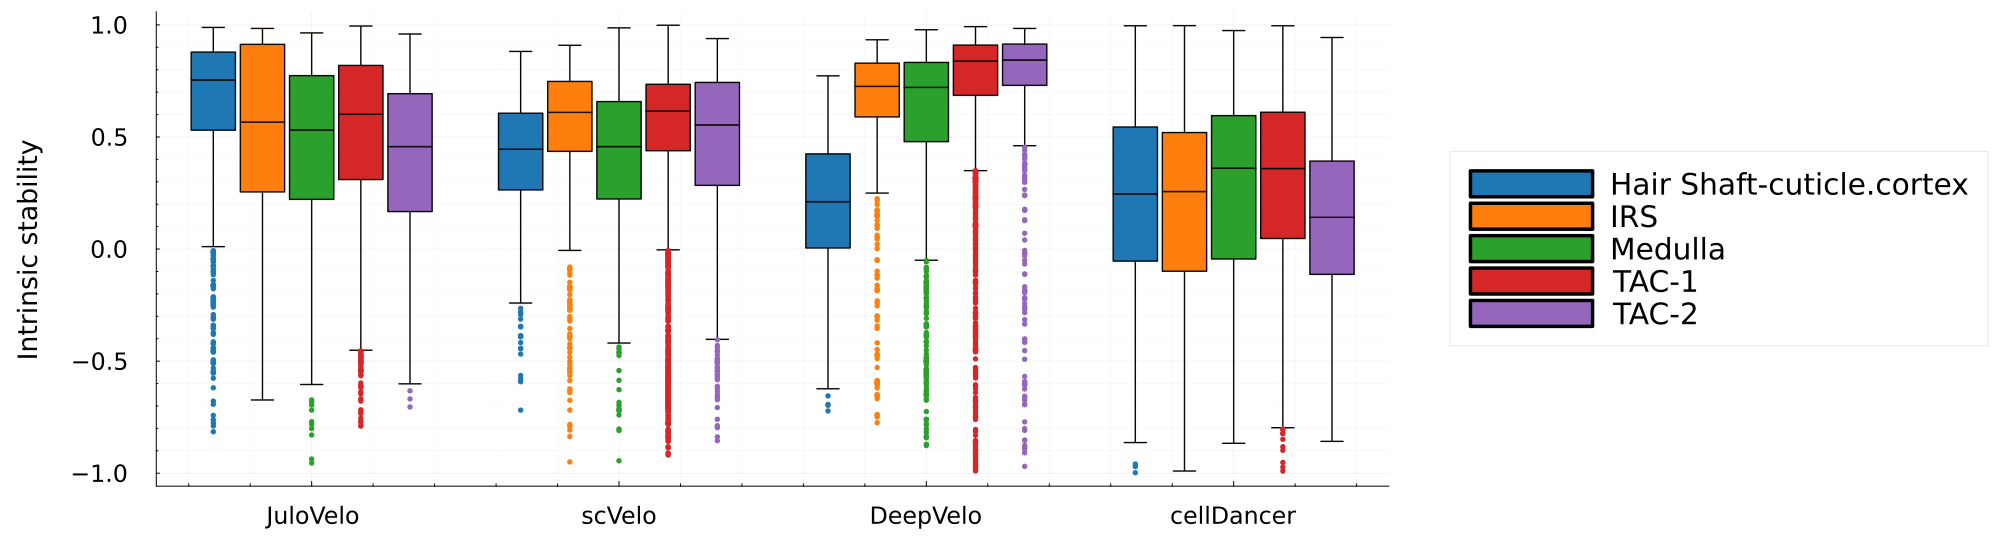

In [16]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [17]:
savefig(p, "figure/mouse_skin_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/Mouse_skin/figure/mouse_skin_intrinsic_stability.png"

# Extrinsic stability

In [18]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 2 entries:
  "TAC-2" => [0.300565, 0.0691051, 0.795289, -0.565996, -0.0310253, -0.864492, …
  "TAC-1" => [0.0636527, -0.290602, 0.104805, -0.313564, 0.320481, 0.837883, 0.…

In [19]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[-0.13139075, 0.50085187, 0.44055712, -0.1041892, -0.08681094, 0.9998387, 0.3614078, 0.92091966, 0.74414593, -0.32761273  …  -0.80474865, 0.026669294, 0.25599858, 0.35345414, -0.45580703, 0.18403426, -0.23743646, 0.8659405, 0.048883874, 0.22560038], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1", "TAC-1"  …  "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2", "TAC-2"])

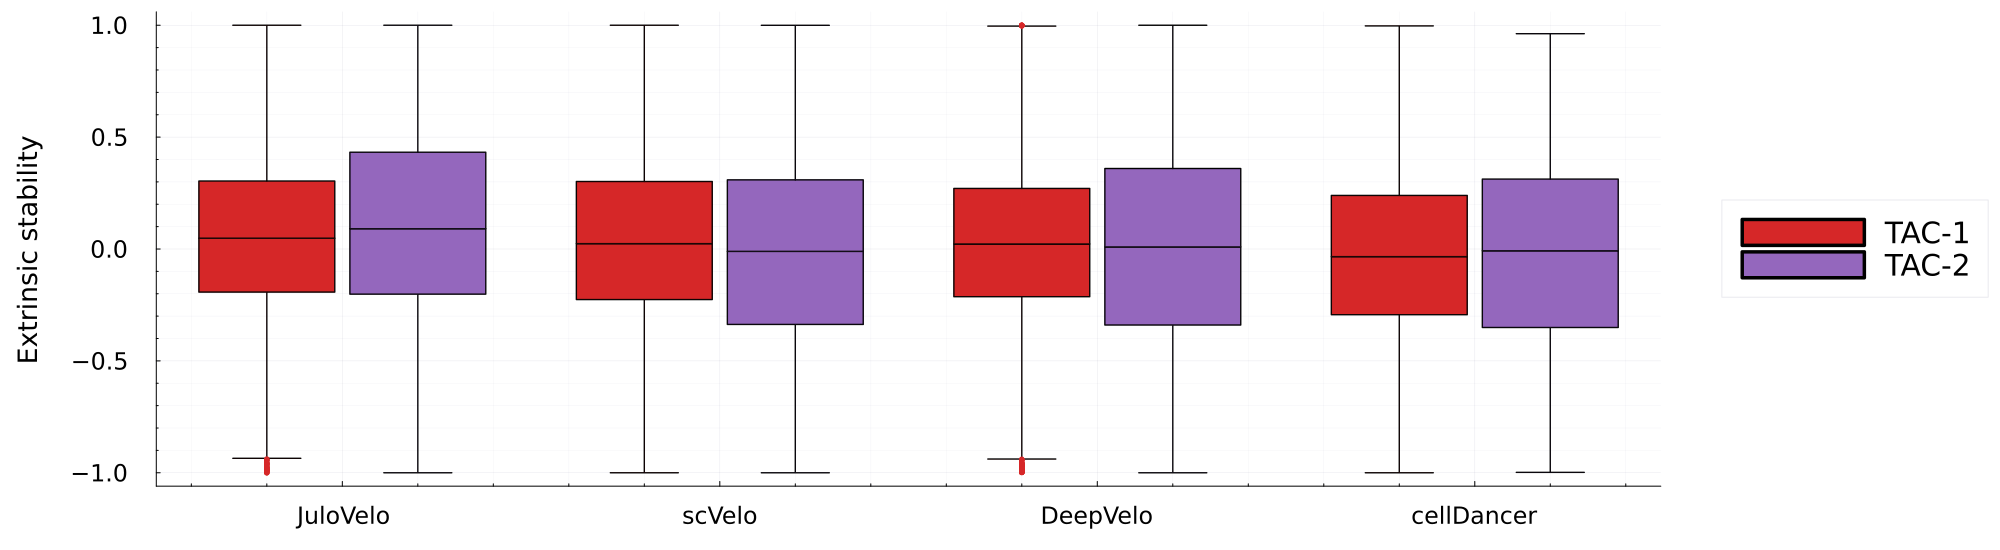

In [20]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [21]:
savefig(p, "figure/mouse_skin_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/Mouse_skin/figure/mouse_skin_extrinsic_stability.png"